In [2]:
import bayes3d as b
import numpy as np
import jax.numpy as jnp
import jax

import utils

In [3]:
import importlib
importlib.reload(utils)
from utils import load_img, scale_remove_and_setup_renderer, add_meshes_to_renderer, c2f_jit, cps_to_pose, get_grids

In [4]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


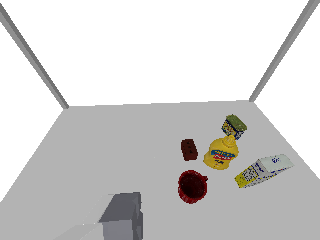

In [5]:
rgbd = load_img("problems/img3.pickle")
b.get_rgb_image(rgbd.rgb)

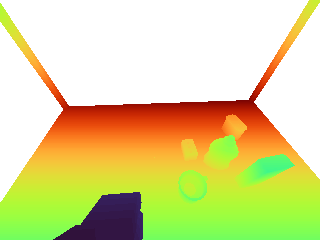

In [6]:
b.get_depth_image(rgbd.depth)

In [7]:
rgbd_scaled_down, obs_img, table_pose, cloud, depth_im = scale_remove_and_setup_renderer(rgbd, scaling_factor=0.3)

b.clear()
b.show_cloud("Obs without table or too-far points", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (96, 96, 1024)


In [8]:
add_meshes_to_renderer()

In [9]:
grid_param_sequence = [
    (0.6, jnp.pi, (20, 20, 15)),
    (0.2, jnp.pi * 3/4, (15, 15, 15)),
    (0.1, jnp.pi * 1/2, (15, 15, 15)),
    (0.05, jnp.pi * 1/3, (15,15,15)),
    (0.02, jnp.pi * 1/4, (9,9,51)),
    # (0.01, jnp.pi * 1/5, (15,15,15)),
    # (0.01, 0.0, (31,31,1)),
    # (0.05, 0.0, (31,31,1))
]

In [10]:
key = jax.random.PRNGKey(30)
cps = jnp.zeros((0,3))
indices = jnp.array([], dtype=jnp.int32)

In [12]:
face_child = 3
best_score = -np.inf
best_index = -1
best_cps = None
best_indices = None
key = jax.random.split(key,2)[0]
low, high = jnp.array([-0.2, -0.2, -jnp.pi]), jnp.array([0.2, 0.2, jnp.pi])
key = jax.random.PRNGKey(30)
for i in range(6):
    print(f"iteration {len(indices) + 1}")
    for next_index in range(len(b.RENDERER.model_box_dims)):
        potential_indices = jnp.concatenate([indices, jnp.array([next_index])])
        potential_cps = jnp.concatenate([cps, jax.random.uniform(key, shape=(1,3,),minval=low, maxval=high)])
        potential_cps, score = c2f_jit(table_pose, face_child, potential_cps, potential_indices, len(potential_indices) - 1, get_grids(grid_param_sequence), obs_img)
        if score > best_score:
            best_index = next_index
            best_score = score
            best_cps = potential_cps
            best_indices = potential_indices
    cps = best_cps
    indices = best_indices

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5


In [13]:
b.clear()
b.show_cloud("obs", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)
poses = cps_to_pose(cps, indices, table_pose, face_child)
for i in range(len(poses)):
    b.show_trimesh(f"{i}", b.RENDERER.meshes[best_indices[i]])
    b.set_pose(f"{i}", poses[i])

# Testing code below

In [343]:
key = jax.random.PRNGKey(31)
# cps = jnp.zeros((0,3))
# indices = jnp.array([], dtype=jnp.int32)
low, high = jnp.array([-0.2, -0.2, -jnp.pi]), jnp.array([0.2, 0.2, jnp.pi])
key = jax.random.split(key,2)[0]

grid = get_grids(grid_param_sequence)[0]
next_index = sugar_idx - 1
face_child = 3
potential_indices = jnp.concatenate([indices, jnp.array([next_index])])
potential_cps = jnp.concatenate([cps, jax.random.uniform(key, shape=(1,3,),minval=low, maxval=high)])
cps_expanded = jnp.repeat(potential_cps[None,...], grid.shape[0], axis=0) # (g, n, 3)
number = len(cps)
cps_expanded = cps_expanded.at[:,number,:].set(cps_expanded[:,number,:] + grid) # (g, n, 3)
poses = utils.cps_to_pose_parallel(cps_expanded, potential_indices, table_pose, face_child)
rendered_images = b.RENDERER.render_many(poses, potential_indices)[...,:3] # (g, h, w, 3)
scores = utils.score_vmap(rendered_images, obs_img)
best_idx = jnp.argmax(scores) # jnp.argsort(scores)[-4]
cps = cps_expanded[best_idx]

ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * one axis had size 3: axis 0 of argument cp of type float32[3,3];
  * one axis had size 2: axis 0 of argument index of type int32[2]

In [333]:
poses.shape

(6000, 2, 4, 4)

In [317]:
b.show_pose(f"best pose", poses[best_idx])

In [341]:
b.clear()
b.show_cloud("obs", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)

b.show_trimesh(f"obj", b.RENDERER.meshes[next_index])
b.set_pose(f"obj", poses[best_idx, number, ...])#$ utils._cp_to_pose(cps, next_index, table_pose))

for i in range(poses.shape[0]):
    if i % 15 == 0:
        b.show_pose(f"pose{i}", poses[i, number, ...])

In [340]:
b.show_pose("best", poses[best_idx, number, ...])

In [202]:
cps__, score__ = utils.grid_and_max(table_pose, face_child, potential_cps, potential_indices, 0, grid, obs_img)

Array(46.484375, dtype=float32)

In [204]:
scores[best_idx]

Array(46.484375, dtype=float32)

In [178]:
grid2 = get_grids(grid_param_sequence)[1]
cps_expanded2 = jnp.repeat(cps[None, ...], grid2.shape[0], axis=0)
cps_expanded2 = cps_expanded2.at[:,number,:].set(cps_expanded2[:,number,:] + grid2) # (g, n, 3)
poses2 = utils.cps_to_pose_parallel(cps_expanded2, potential_indices, table_pose, face_child)
rendered_images2 = b.RENDERER.render_many(poses2, potential_indices)[...,:3] # (g, h, w, 3)
scores2 = utils.score_vmap(rendered_images2, obs_img)
best_idx2 = jnp.argmax(scores2) # jnp.argsort(scores)[-4]
cps2 = cps_expanded2[best_idx2]

In [179]:
b.clear()
b.show_cloud("obs", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)

b.show_trimesh(f"obj", b.RENDERER.meshes[next_index])
b.set_pose(f"obj", poses2[best_idx2])#$ utils._cp_to_pose(cps, next_index, table_pose))

In [180]:
# for i in range(poses.shape[0]):
#     b.show_pose(f"pose{i}", poses[i, 0, ...])
b.clear()
b.show_cloud("obs", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)

b.show_trimesh(f"obj", b.RENDERER.meshes[next_index])
b.set_pose(f"obj", poses2[best_idx2])#$ utils._cp_to_pose(cps, next_index, table_pose))

# show ever 100th pose
# for i in range(poses2.shape[0]):
#     if i % 10 == 0:
#         b.show_pose(f"pose2{i}", poses2[i, 0, ...])

In [181]:
scores2[best_idx2]

Array(46.585648, dtype=float32)

In [264]:
import os
import glob
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
list = glob.glob(os.path.join(model_dir, "*.ply"))

# get numbers out of array of strings like `'/home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000007.ply'`
ycb_order = [int(s.split("/")[-1].split("_")[-1].split(".")[0]) for s in list]

def ycb_index_to_render_index(ycb_index):
    return np.where(np.array(ycb_order) == ycb_index)[0][0] + 1

In [265]:
sugar_idx = ycb_index_to_render_index(3)
sugar_idx

20

In [ ]:

grid = get_grids(grid_param_sequence)[0]
next_index = 1
face_child = 3
potential_indices = jnp.concatenate([indices, jnp.array([next_index])])
potential_cps = jnp.concatenate([cps, jax.random.uniform(key, shape=(1,3,),minval=low, maxval=high)])
cps_expanded = jnp.repeat(potential_cps[None,...], grid.shape[0], axis=0) # (g, n, 3)
number = 0
cps_expanded = cps_expanded.at[:,number,:].set(cps_expanded[:,number,:] + grid) # (g, n, 3)
poses = utils.cps_to_pose_parallel(cps_expanded, potential_indices, table_pose, face_child)
rendered_images = b.RENDERER.render_many(poses, potential_indices)[...,:3] # (g, h, w, 3)
scores = utils.score_vmap(rendered_images, obs_img)
best_idx = jnp.argmax(scores) # jnp.argsort(scores)[-4]
cps = cps_expanded[best_idx]

In [215]:
b.clear()
b.show_cloud("obs", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)
poses = cps_to_pose(cps, indices, table_pose, face_child)
for i in range(len(poses)):
    b.show_trimesh(f"{i}", b.RENDERER.meshes[best_indices[i]])
    b.set_pose(f"{i}", poses[i])

In [152]:
get_grids(grid_param_sequence)[1]

Array([[-0.2      , -0.2      , -2.3561945],
       [-0.2      , -0.2      , -2.0195951],
       [-0.2      , -0.2      , -1.6829962],
       ...,
       [ 0.2      ,  0.2      ,  1.6829963],
       [ 0.2      ,  0.2      ,  2.0195956],
       [ 0.2      ,  0.2      ,  2.3561945]], dtype=float32)